# Using C3PY

C3PY provides a set of check functions to check if the provided history is causally consistent given the sequential specification.

In [1]:
from pprint import pprint

from c3py import (
    History,
    Operation,
    RWMemorySpecification,
    check_CC,
    check_CCv,
    check_CM,
)
from helper import view_pydot


If Jupyter notebook cannot find the module, please make sure that the Kernel is using the correct Python environment created by rye.

## Sequential Specification

The consistency of the history is checked against the sequential specification. The sequential specification defines the set of all possible sequential histories.

To define a sequential specification, implement the `Specification` abstract class and implement the `start` and `step` methods. The `start` method should return the initial state of the sequential specification. The `step` method should take the current state and the `Instruction`, which describes the operation performed on the abstract data type, and return the next state.

The `Instruction` class has `method` and `args` fields. These fields describe the operation performed on the abstract data type.

The library provides `RWMemorySpecification` that serves as a sequential specification for a read-write memory.

## History

A history is a partially ordered set of operations. Each operation is represented by an `Operation` object. `Operation` is like `Instruction` but has an additional `ret` field that represents the return value of the operation.

To define a history, initialize a `History` object with a dictionary of list of `Operation`s. The dictionary key is the process id and the list of `Operation`s is the operations performed by the process.

For example, the following code creates a history with two processes. The first process (with id `a`) performs three write operations and the second process (with id `b`) performs one write operation and three read operations.

In [2]:
h = History(
    {
        "a": [
            Operation("wr", ("z", 1)),
            Operation("wr", ("x", 1)),
            Operation("wr", ("y", 1)),
        ],
        "b": [
            Operation("wr", ("x", 2)),
            Operation("rd", "z", None),
            Operation("rd", "y", 1),
            Operation("rd", "x", 2),
        ],
    }
)

### Causal Consistency (CC)

The library can check against three types of causal consistency: `CC`, `CM`, and `CCv`.

`check_CC` checks if the history is CC. It returns `CCResult`, which has the `is_CC` field that is `True` if the history is CC and `False` otherwise. If the history is CC, the `co` and `serializations` fields are also provided. `co` is the causal order of the history that satisfies the CC condition. `serialization` is a dictionary that maps the operation id to the serialization order.

In [3]:
cc = check_CC(h, RWMemorySpecification())
print(cc.is_CC)

True


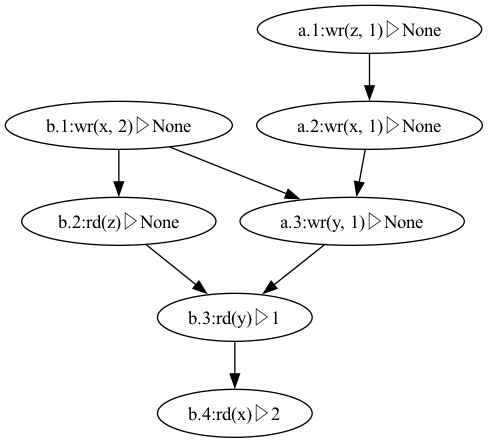

{'a.1': [a.1:wr(z, 1)▷None],
 'a.2': [a.1:wr(z, 1), a.2:wr(x, 1)▷None],
 'a.3': [b.1:wr(x, 2), a.1:wr(z, 1), a.2:wr(x, 1), a.3:wr(y, 1)▷None],
 'b.1': [b.1:wr(x, 2)▷None],
 'b.2': [b.1:wr(x, 2), b.2:rd(z)▷None],
 'b.3': [b.1:wr(x, 2),
         b.2:rd(z),
         a.1:wr(z, 1),
         a.2:wr(x, 1),
         a.3:wr(y, 1),
         b.3:rd(y)▷1],
 'b.4': [a.1:wr(z, 1),
         a.2:wr(x, 1),
         b.1:wr(x, 2),
         a.3:wr(y, 1),
         b.2:rd(z),
         b.3:rd(y),
         b.4:rd(x)▷2]}


In [4]:
view_pydot(cc.causal_history.visualize())
pprint(cc.serializations)

## Causal Memory (CM)

`check_CM` checks if the history is CM. It returns `CMResult`, which has the `is_CM` field that is `True` if the history is CM and `False` otherwise. If the history is CM, the `co` and `serializations` fields are also provided. `co` is the causal order of the history that satisfies the CM condition. `serialization` is a dictionary that maps the operation id to the serialization order.

In [5]:
cm = check_CM(h, RWMemorySpecification())
print(cm.is_CM)
print(cm.causal_history)

False
None


## Causal Convergence (CCv)

`check_CCv` checks if the history is CCv. It returns `CCvResult`, which has the `is_CCv` field that is `True` if the history is CCv and `False` otherwise. If the history is CCv, the `co` and `arb` fields are also provided. `co` is the causal order of the history and `arb` is an arbitration order that satisfies the CCv condition.

In [9]:
cv = check_CCv(h, RWMemorySpecification())
print(cv.is_CCv)

True


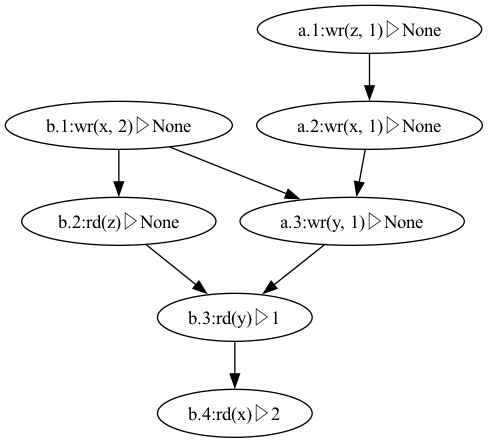

{'a.1': [a.1:wr(z, 1)▷None],
 'a.2': [a.1:wr(z, 1), a.2:wr(x, 1)▷None],
 'a.3': [a.1:wr(z, 1), a.2:wr(x, 1), b.1:wr(x, 2), a.3:wr(y, 1)▷None],
 'b.1': [b.1:wr(x, 2)▷None],
 'b.2': [b.1:wr(x, 2), b.2:rd(z)▷None],
 'b.3': [a.1:wr(z, 1),
         a.2:wr(x, 1),
         b.1:wr(x, 2),
         a.3:wr(y, 1),
         b.2:rd(z),
         b.3:rd(y)▷1],
 'b.4': [a.1:wr(z, 1),
         a.2:wr(x, 1),
         b.1:wr(x, 2),
         a.3:wr(y, 1),
         b.2:rd(z),
         b.3:rd(y),
         b.4:rd(x)▷2]}


In [10]:
view_pydot(cv.causal_history.visualize())
pprint(cv.arbitrations)